target_entropy = math.log(action_dim)

loss_alpha = -(alpha_log * (entropy - target_entropy)).mean()

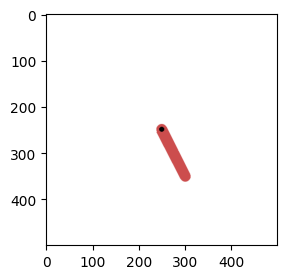

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch


class ModelAction(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
        )
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )
        self.sigma = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        state = self.s(state)
        return self.mu(state), self.sigma(state).exp()


model_action = ModelAction()

model_action(torch.randn(2, 3))

(tensor([[0.2615],
         [0.3693]], grad_fn=<TanhBackward0>),
 tensor([[0.9110],
         [0.9877]], grad_fn=<ExpBackward0>))

In [3]:
model_value1 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value2 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value1_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value2_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value1_next.load_state_dict(model_value1.state_dict())
model_value2_next.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4))

tensor([[-0.0139],
        [ 0.0910]], grad_fn=<AddmmBackward0>)

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        #根据概率采样
        mu, sigma = model_action(torch.FloatTensor(state).reshape(1, 3))
        action = random.normalvariate(mu=mu.item(), sigma=sigma.item())

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


49.772290302087114

In [5]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(self.pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
        action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()

len(pool), pool[0]

C:\Users\User\AppData\Local\Temp\ipykernel_41172\1957677715.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(200,
 (array([-0.9660977 ,  0.2581767 ,  0.46676618], dtype=float32),
  0.8316136747812629,
  -0.04019909381200448,
  array([-0.9768396 ,  0.21397297,  0.90988284], dtype=float32),
  False))

In [6]:
alpha_log = torch.nn.Parameter(torch.FloatTensor([-1.0]))

optimizer_alpha = torch.optim.Adam([alpha_log], lr=1e-4)
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=5e-3)
optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=5e-3)


def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.995 + _from.data * 0.005
        _to.data.copy_(value)


def get_action_entropy(state):
    mu, sigma = model_action(torch.FloatTensor(state).reshape(-1, 3))
    dist = torch.distributions.Normal(mu, sigma)

    action = dist.rsample()

    #求分布的熵
    entropy = dist.entropy()

    return action, entropy


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

In [7]:
def train_value(state, action, reward, next_state, over):
    requires_grad(model_value1, True)
    requires_grad(model_value2, True)
    requires_grad(model_action, False)
    alpha_log.requires_grad_(False)

    #计算target
    with torch.no_grad():
        #计算动作和熵
        next_action, entropy = get_action_entropy(next_state)

        #评估next_state的价值
        input = torch.cat([next_state, next_action], dim=1)
        target1 = model_value1_next(input)
        target2 = model_value2_next(input)
        target = torch.min(target1, target2)

    #加权熵,熵越大越好
    target = target + alpha_log.exp() * entropy
    target = target * 0.99 * (1 - over) + reward

    #计算value
    value = model_value1(torch.cat([state, action], dim=1))
    loss = torch.nn.functional.mse_loss(value, target)
    loss.backward()
    optimizer_value1.step()
    optimizer_value1.zero_grad()

    value = model_value2(torch.cat([state, action], dim=1))
    loss = torch.nn.functional.mse_loss(value, target)
    loss.backward()
    optimizer_value2.step()
    optimizer_value2.zero_grad()

    return loss.item()


train_value(state, action, reward, next_state, over)

0.3467281758785248

In [8]:
def train_action(state):
    requires_grad(model_value1, False)
    requires_grad(model_value2, False)
    requires_grad(model_action, True)
    alpha_log.requires_grad_(False)

    #计算action和熵
    action, entropy = get_action_entropy(state)

    #计算value
    value1 = model_value1(torch.cat([state, action], dim=1))
    value2 = model_value2(torch.cat([state, action], dim=1))
    value = torch.min(value1, value2)

    #加权熵,熵越大越好
    loss = -(value + alpha_log.exp() * entropy).mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item(), entropy.detach()


_, entropy = train_action(state)

entropy.shape

torch.Size([64, 1])

In [9]:
def train_alpha(entropy):
    import math

    requires_grad(model_value1, False)
    requires_grad(model_value2, False)
    requires_grad(model_action, False)
    alpha_log.requires_grad_(True)

    target_entropy = math.log(1)
    target_entropy = 10
    loss_alpha = -(alpha_log * (entropy - target_entropy)).mean()

    optimizer_alpha.zero_grad()
    loss_alpha.backward()
    optimizer_alpha.step()

    return loss_alpha.item()


train_alpha(entropy)

-8.495987892150879

In [10]:
def train():
    model_action.train()
    model_value1.train()
    model_value2.train()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        pool.update()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = pool.sample()

            #训练
            train_value(state, action, reward, next_state, over)
            _, entropy = train_action(state)
            soft_update(model_value1, model_value1_next)
            soft_update(model_value2, model_value2_next)
            train_alpha(entropy)

        if epoch % 20 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), alpha_log.exp().item(), test_result)


train()

0 400 0.36068883538246155 19.63507381059437
20 4400 0.24188385903835297 69.98000326770665
40 8400 0.16212883591651917 79.44390850268368
60 12400 0.108026884496212 153.10649735591417
80 16400 0.07196647673845291 175.94559264873632
100 20000 0.04806067794561386 174.3460338350998
120 20000 0.03209279850125313 177.08875266064703
140 20000 0.021481040865182877 180.50862044688068
160 20000 0.014397842809557915 173.2436166244427
180 20000 0.00964196678251028 179.959892100814


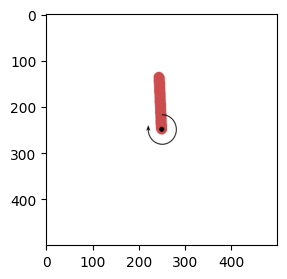

184.6633406916075

In [11]:
play(True)[-1]